# **Programa Especializado en Credit Scoring con Python**
<img src="../../figuras/logo.png" width="200"/>

## 📊 **Sesión 3: Análisis Exploratorio de Datos y Tratamiento de Variables.**

**Docente**: Enzo Infantes Zúñiga  
**Contacto**: <enzo.infantes28@gmail.com>  
**LinkedIn**: [enzo-infantes](https://www.linkedin.com/in/enzo-infantes/)



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ptitprince as pt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

import os

absolute_path = os.path.dirname(os.path.dirname(os.getcwd()))
data_path = os.path.join(absolute_path, "data", "s03")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:,.4f}'.format)

## 🎯 **Objetivos de la sesión**

Al finalizar esta clase el participante será capaz de:

- Realizar análisis bivariado y multivariado
- Mostrar las vistas más útiles para el entendimiento del dataset
- Justificar la elección de default
- Realizar los tratamiento más comunes a las variables explicativas (outliers, nulos, etc)

## 📊 **0. Dataset**

El dataset contiene información de clientes únicos una determinada fecha de cohorte con sus variables sociodemográficas, económicas y crediticias más relevantes para la toma de decisión del banco. 

### 🛠️ **Especificación de Variables**

| N° | Variable | Descripción | Categoría |
| :---: | :--- | :--- | :---: |
| **1** | `mora` | **Variable Objetivo (Target)**: {0: paga al día, 1: cliente moroso}. | 🎯 |
| **2** | `atraso` | Atraso histórico del cliente medido en días. | ⏳ |
| **3** | `vivienda` | Tipo de vivienda del cliente (Propia, Familiar, etc.). | 🏠 |
| **4** | `edad` | Edad del cliente en años. | 👤 |
| **5** | `dias_lab` | Días laborados en su actual empleo (Estabilidad). | 💼 |
| **6** | `exp_sf` | Meses de experiencia en el sistema financiero. | 📈 |
| **7** | `nivel_ahorro` | Índice de nivel de ahorro: **0** (sin ahorros) a **12** (alto). | 💰 |
| **8** | `ingreso` | Ingresos mensuales del cliente. | 💵 |
| **9** | `linea_sf` | Línea de crédito disponible en el sistema financiero. | 💳 |
| **10** | `deuda_sf` | Deuda total actual en el sistema financiero. | 📉 |
| **11** | `score` | Calificación crediticia: A mayor score, mejor perfil. | 🏆 |
| **12** | `zona` | Departamento de residencia del cliente. | 📍 |
| **13** | `clasif_sbs` | **Clasificación SBS**: {0: Normal, 1: CPP, 2: Def, 3: Dud, 4: Pér}. | 🏛️ |
| **14** | `nivel_educ` | Nivel educativo máximo alcanzado. | 🎓 |

### 📝 **Notas de Negocio**
* **Target sugerido:** Definir el incumplimiento basado en el cruce de `atraso` > 30 días y `clasif_sbs` > 0.
* **Contexto:** Producto de microfinanzas o consumo masivo con alta concentración en Lima, Perú (59%).

Fuente:  [dataset](https://www.kaggle.com/datasets/luishcaldernb/morosidad/data)


In [3]:
df = pd.read_csv(os.path.join(data_path, "data.csv"))
df.head()

,mora,atraso,vivienda,edad,dias_lab,exp_sf,nivel_ahorro,ingreso,linea_sf,deuda_sf,score,zona,clasif_sbs,nivel_educ
0,0,235,FAMILIAR,30,3748,93.0000,5,"3,500.0000",NaN,0.0000,214,Lima,4,UNIVERSITARIA
1,0,18,FAMILIAR,32,4598,9.0000,12,900.0000,"1,824.6700","1,933.7500",175,La Libertad,1,TECNICA
2,0,0,FAMILIAR,26,5148,8.0000,2,"2,400.0000","2,797.3800",188.2900,187,Lima,0,UNIVERSITARIA
3,0,0,FAMILIAR,36,5179,20.0000,12,"2,700.0000",NaN,0.0000,187,Ancash,0,TECNICA
4,0,0,FAMILIAR,46,3960,NaN,1,"3,100.0000","2,000.0000","11,010.6500",189,Lima,0,TECNICA


## **1. Definición de Default**

Para definir el "punto de no retorno", en riesgo bancario usamos una Matriz de **Roll Rates**. Esta tabla de doble entrada te permite ver cuántos clientes que caen en un tramo de mora (ej. 1-30 días) terminan "rodando" al siguiente tramo (31-60 días) en lugar de curarse (volver a 0)

| De (Enero) \ A (Febrero) | 0d (Al día) | 1-30d       | 31-60d      | 90+ (Default) |
|---------------------------|-------------|-------------|-------------|---------------|
| 1-30d                     | 20% (Cura)  | 10% (Stay)  | 70% (Roll)  | 0%            |

- ​🔴​ **El Roll** (70%): Es el semáforo rojo. Es la tasa de rodamiento; el 70% de los saldos "ruedan" hacia una mora más grave (31-60d). Indica un deterioro agresivo de la cartera.
- ​🟢​ **La Cura** (20%): Es el semáforo verde. Solo el 20% de los clientes logra pagar y volver a estar al día. Si esta tasa es baja, la cobranza preventiva está fallando.
- 🟡 **El Stay** (10%): Es el semáforo ámbar. Son clientes que hicieron pagos parciales para no saltar de tramo, pero siguen atrapados en mora.

Al no contar con dos fotos mensuales consecutivas, utilizamos una **Matriz de Validación Cruzada** (Proxy de Roll Rate). Esta matriz no mide el movimiento en el tiempo, sino la consistencia del deterioro: comparamos nuestros **días de atraso** internos contra la **clasificación del regulador** (SBS).

Lo que buscamos identificar es el **punto no retorno/quiebre**; es decir, el tramo de mora donde la probabilidad de que el cliente mantenga una calificación de "Normal" (SBS 0) se desplome. Si observamos que en el tramo de 31-60 días el porcentaje de clientes en SBS 0 es residual, confirmamos que ese es nuestro umbral óptimo para definir el Default.

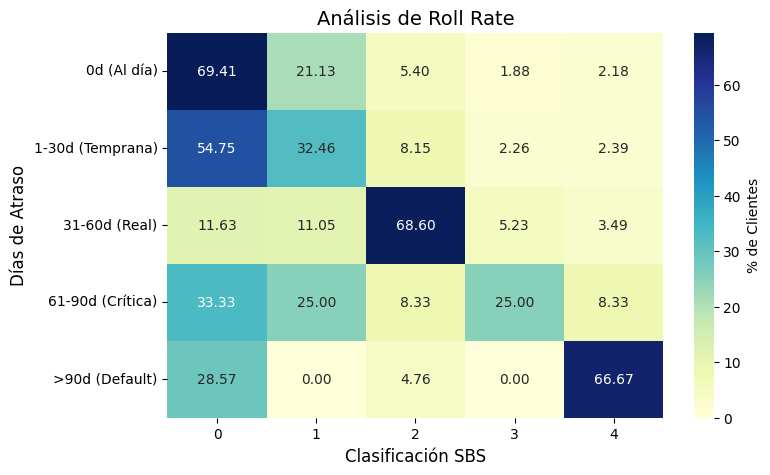

In [4]:
bins = [-1, 0, 30, 60, 90, 1000] 
nombres_tramos = ['0d (Al día)', '1-30d (Temprana)', '31-60d (Real)', '61-90d (Crítica)', '>90d (Default)']

df['tramo_atraso'] = pd.cut(df['atraso'], bins=bins, labels=nombres_tramos)

matriz_sbs = pd.crosstab(df['tramo_atraso'], df['clasif_sbs'], normalize='index') * 100

plt.figure(figsize=(8, 5))
sns.heatmap(matriz_sbs, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': '% de Clientes'})
plt.title('Análisis de Roll Rate', fontsize=14)
plt.xlabel('Clasificación SBS', fontsize=12)
plt.ylabel('Días de Atraso', fontsize=12)
plt.show()

**Conclusión**: El análisis revela que el tramo de **1-30 días** es una zona clave donde la mitad de los clientes aún son vistos como normales (SBS 0), pero ya hay un gran porcentaje den clasificacion CPP. Pero, al cruzar la barrera de los 30 días, el 77.3% ya presenta un deterioro severo. Por lo tanto, el **punto de no retorno** estadístico en esta data son los **30 días**.

Aunque el **punto de no retorno** regulatorio (SBS 2+) se consolida cumplidos los 30 días, para fines de **modelamiento predictivo** hemos optado por una definición de **Default > 15 días**. 

1. **Deterioro Inmediato:** El análisis muestra que en el tramo de mora temprana, un **32.5%** de los clientes ya pierde la categoría 'Normal' (SBS 0) para entrar en 'Problemas Potenciales' (SBS 1).
2. **Sensibilidad del Modelo:** Una definición de 30 días genera una tasa de mora de solo **2.4%**, lo cual limitaría la capacidad del modelo para identificar patrones de riesgo. 
3. **Sentido de Negocio:** En productos de alta rotación, esperar a los 30 días es actuar sobre el "cadáver" financiero; capturar el incumplimiento a los 15 días permite una gestión de cobranza preventiva mucho más efectiva.

In [5]:
df['default'] = np.where(df['atraso'] > 15, 1, 0)
round(df['default'].value_counts(normalize=True), 4)*100

default
0   88.5900
1   11.4100
Name: proportion, dtype: float64

# **2. EAD**

En credit scoring no hacemos EDA “por curiosidad”. Lo hacemos para responder 3 preguntas críticas:

- ¿Qué significa realmente default?
- ¿Qué variables contienen señal predictiva?
- ¿Qué problemas de calidad podrían destruir mi modelo?

```“Un modelo bueno no nace en el algoritmo, nace en el EDA.”```

## **2.1 Analisis Univariado**

Los puntos mas importantes en este punto son:
- Tipo de datos
- Valores Nulos
- Distribucion de las variables
- Estadisticos Descriptivos

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8399 entries, 0 to 8398
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   mora          8399 non-null   int64   
 1   atraso        8399 non-null   int64   
 2   vivienda      8399 non-null   object  
 3   edad          8399 non-null   int64   
 4   dias_lab      8399 non-null   int64   
 5   exp_sf        6569 non-null   float64 
 6   nivel_ahorro  8399 non-null   int64   
 7   ingreso       8399 non-null   float64 
 8   linea_sf      7272 non-null   float64 
 9   deuda_sf      7938 non-null   float64 
 10  score         8399 non-null   int64   
 11  zona          8399 non-null   object  
 12  clasif_sbs    8399 non-null   int64   
 13  nivel_educ    8399 non-null   object  
 14  tramo_atraso  8399 non-null   category
 15  default       8399 non-null   int32   
dtypes: category(1), float64(4), int32(1), int64(7), object(3)
memory usage: 960.0+ KB


In [7]:
df.isnull().mean().to_frame().sort_values(by=0, ascending=False).T *100

,exp_sf,linea_sf,deuda_sf,mora,atraso,vivienda,edad,dias_lab,nivel_ahorro,ingreso,score,zona,clasif_sbs,nivel_educ,tramo_atraso,default
0,21.7883,13.4183,5.4887,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [8]:
df.describe()

,mora,atraso,edad,dias_lab,exp_sf,nivel_ahorro,ingreso,linea_sf,deuda_sf,score,clasif_sbs,default
count,"8,399.0000","8,399.0000","8,399.0000","8,399.0000","6,569.0000","8,399.0000","8,399.0000","7,272.0000","7,938.0000","8,399.0000","8,399.0000","8,399.0000"
mean,0.7043,4.4632,36.3991,"5,555.8888",32.4016,10.5932,"4,350.4070","11,987.2410","6,110.7243",196.6200,0.5635,0.1141
std,0.4564,14.2708,9.8258,"2,153.2441",32.8662,3.3746,"5,367.0590","21,322.8017","11,177.9898",19.5443,0.9056,0.3179
min,0.0000,0.0000,20.0000,"2,956.0000",0.0000,0.0000,123.7000,0.0000,0.0000,134.0000,0.0000,0.0000
25%,0.0000,0.0000,29.0000,"4,174.0000",7.0000,12.0000,"1,366.6700","1,169.3725",478.3200,182.0000,0.0000,0.0000
50%,1.0000,0.0000,34.0000,"4,904.0000",20.0000,12.0000,"2,400.0000","4,030.1200","2,258.7550",197.0000,0.0000,0.0000
75%,1.0000,2.0000,42.0000,"6,182.0000",51.0000,12.0000,"4,900.0000","12,086.6275","5,755.1500",212.0000,1.0000,0.0000
max,1.0000,245.0000,85.0000,"20,700.0000",130.0000,12.0000,"30,000.0000","121,543.4000","57,094.3800",266.0000,4.0000,1.0000


array([[<Axes: title={'center': 'mora'}>,
        <Axes: title={'center': 'atraso'}>,
        <Axes: title={'center': 'edad'}>],
       [<Axes: title={'center': 'dias_lab'}>,
        <Axes: title={'center': 'exp_sf'}>,
        <Axes: title={'center': 'nivel_ahorro'}>],
       [<Axes: title={'center': 'ingreso'}>,
        <Axes: title={'center': 'linea_sf'}>,
        <Axes: title={'center': 'deuda_sf'}>],
       [<Axes: title={'center': 'score'}>,
        <Axes: title={'center': 'clasif_sbs'}>,
        <Axes: title={'center': 'default'}>]], dtype=object)

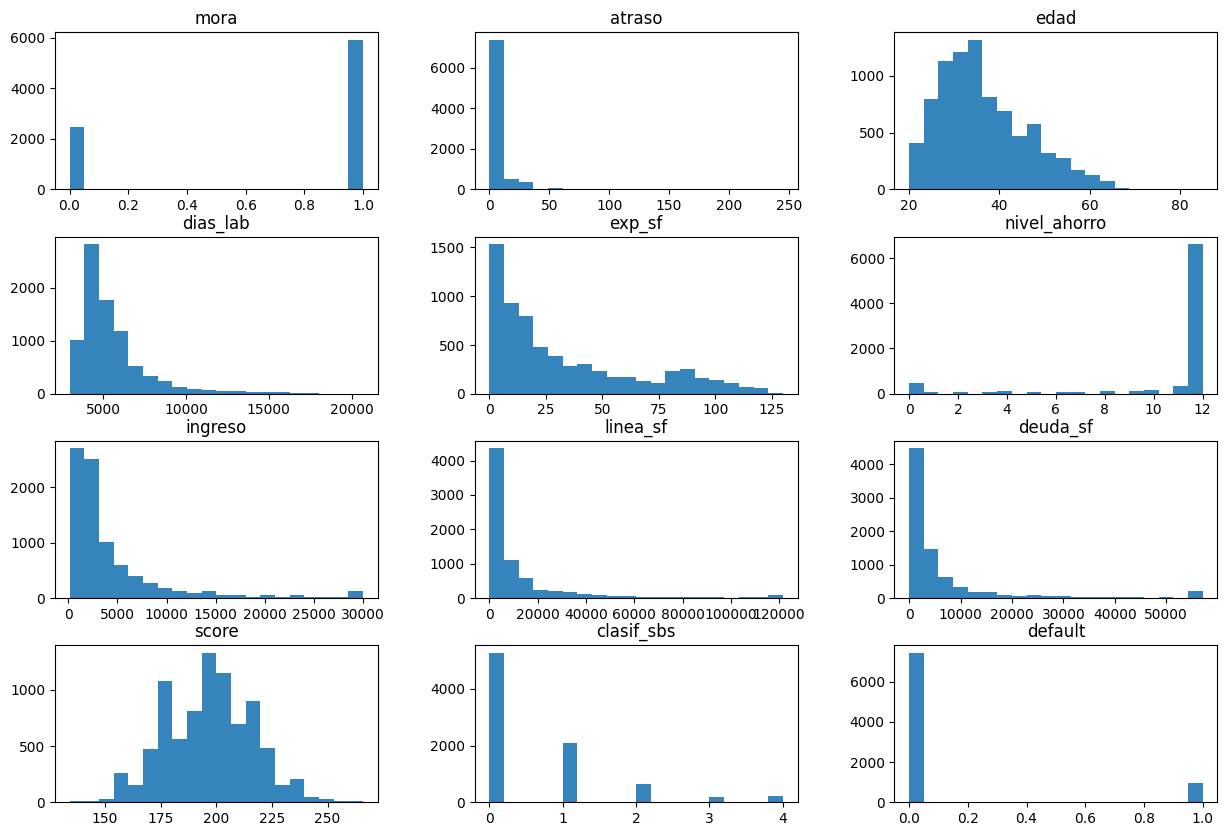

In [9]:
df.hist(bins=20, figsize=(15,10), alpha=0.9, grid=False)

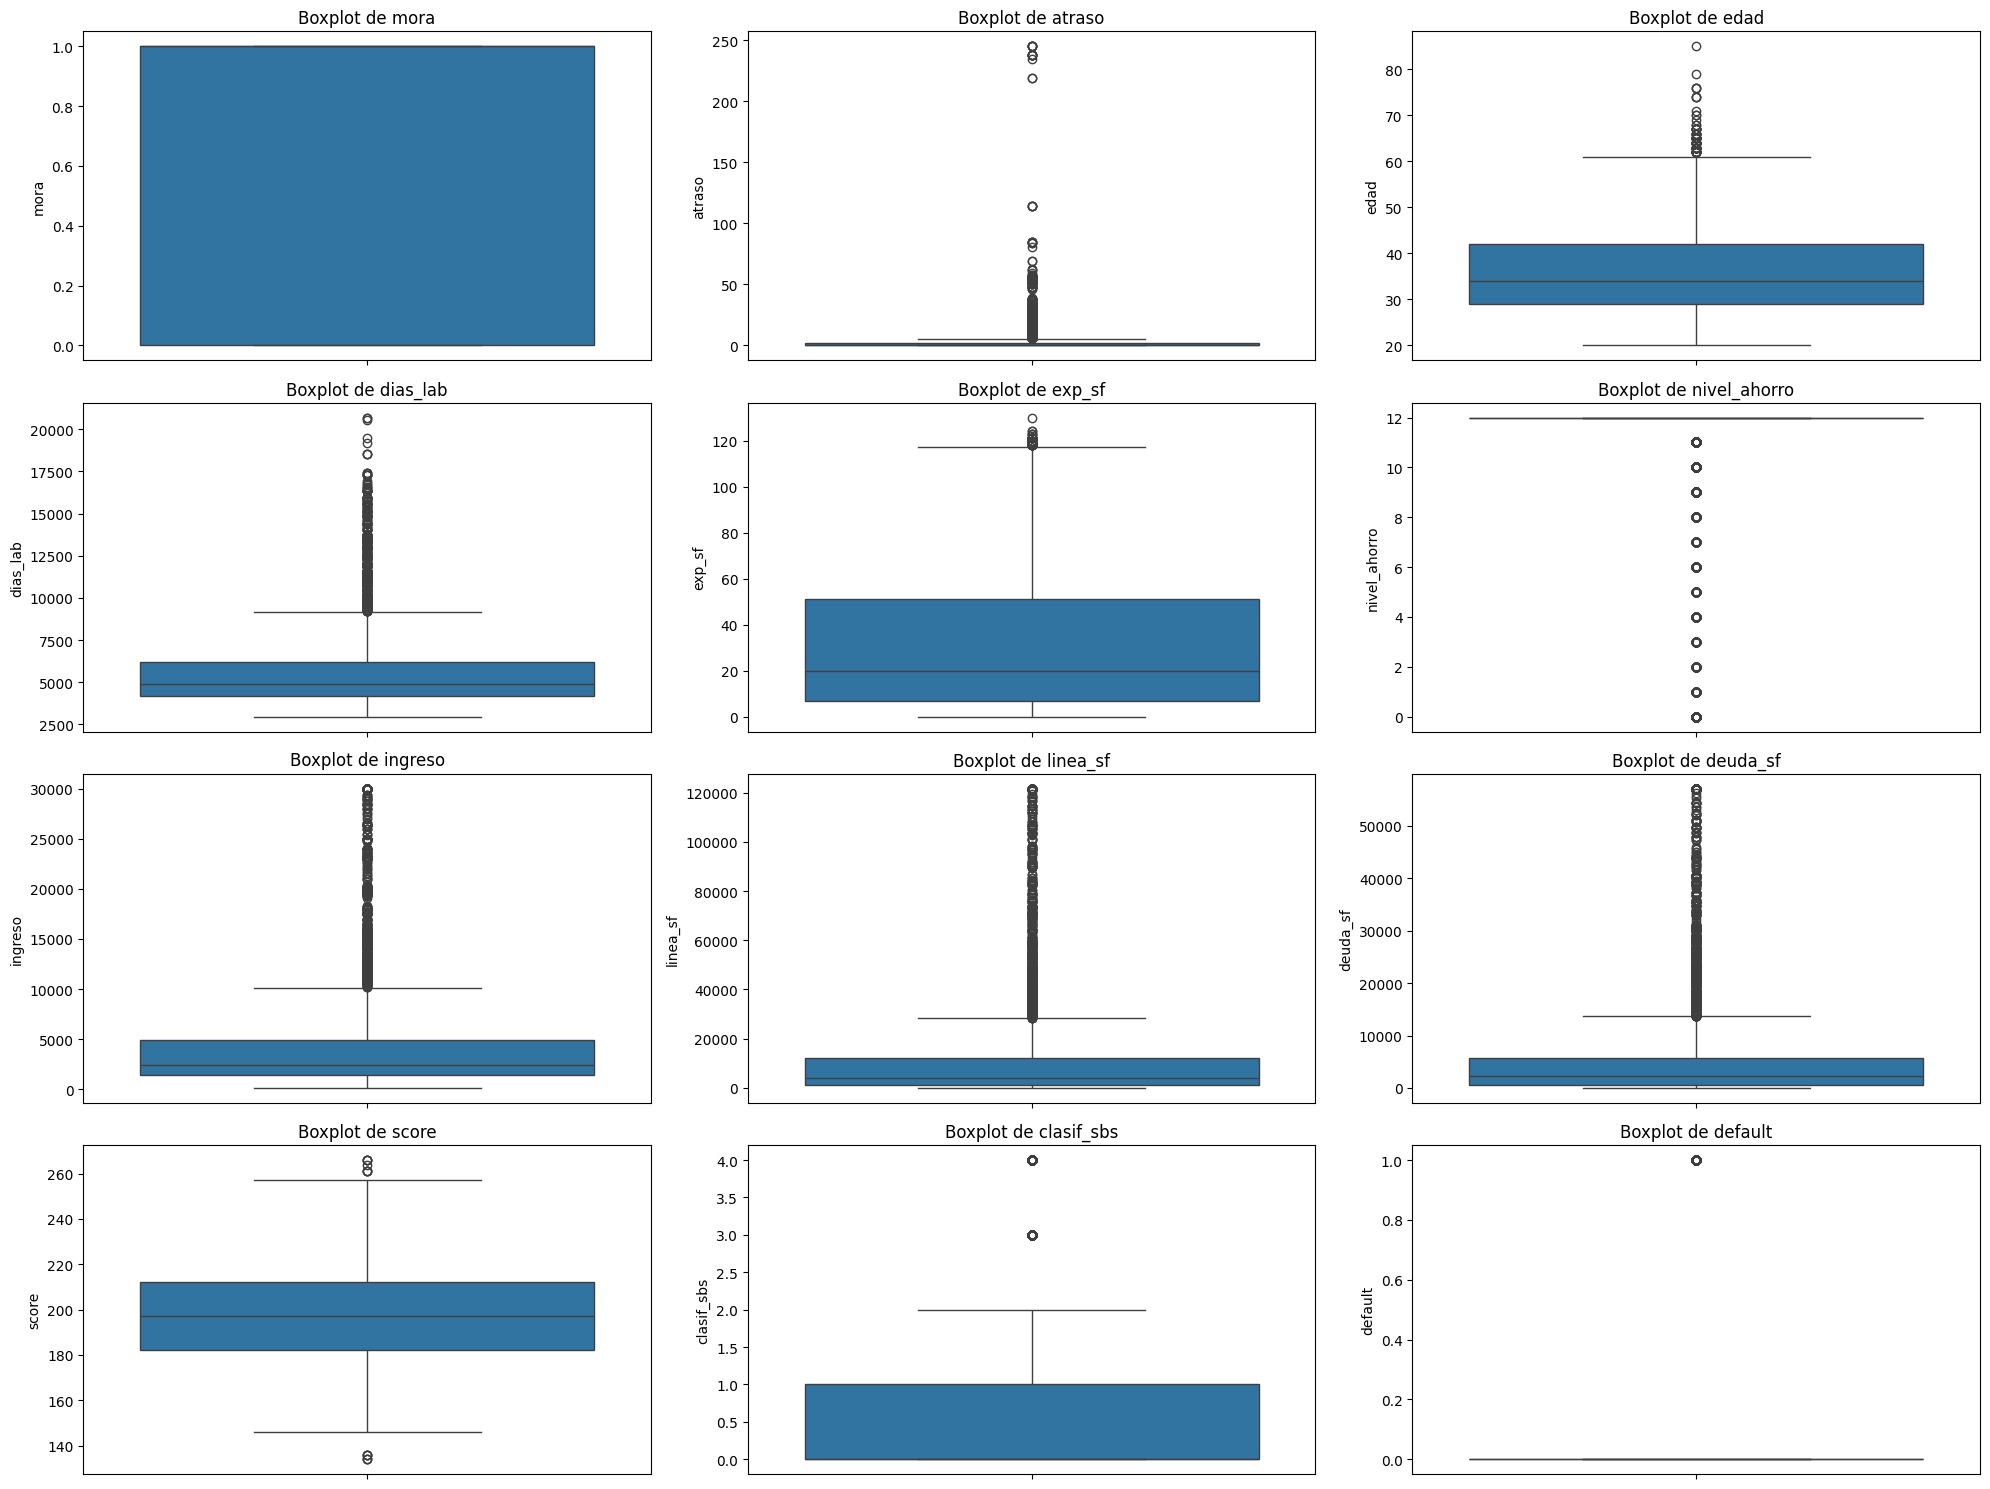

In [10]:
v_num = df.select_dtypes(include='number').columns.tolist()

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 15))
for col, ax in zip(v_num, axes.flatten()[:len(v_num)]):
    sns.boxplot(data=df, y=col, ax=ax)
    ax.set_title(f'Boxplot de {col}')
    ax.grid(False)
plt.tight_layout()
plt.show()

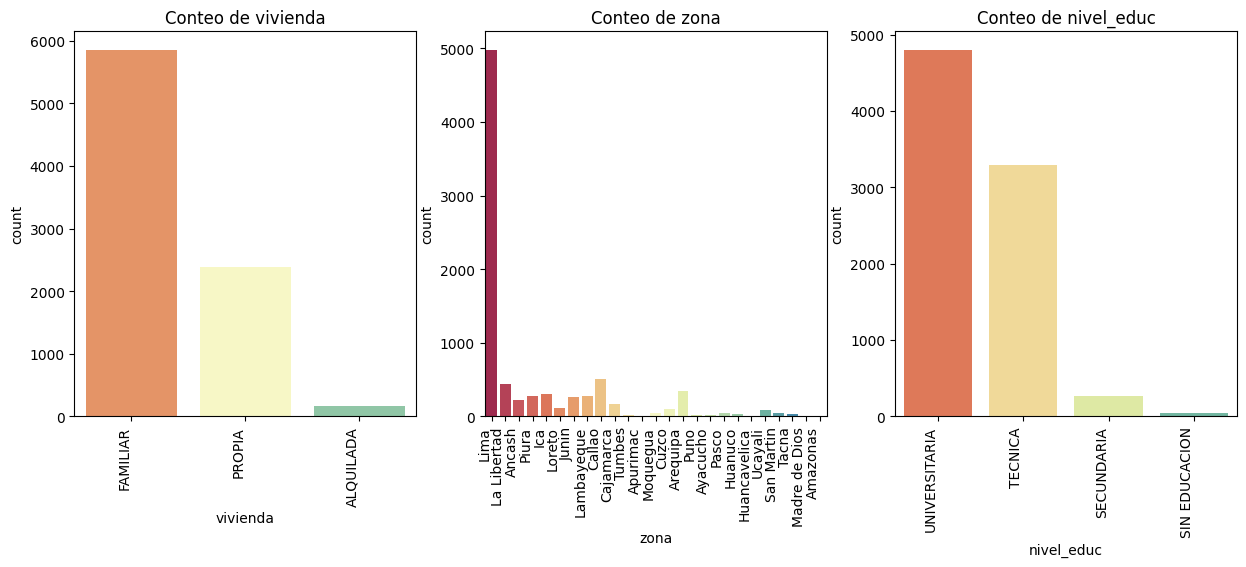

In [11]:
v_cat = df.select_dtypes(include='object').columns.tolist()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for col, ax in zip(v_cat, axes.flatten()[:len(v_cat)]):
	sns.countplot(data=df, x=col, ax=ax, palette="Spectral")
	ax.set_title(f'Conteo de {col}')
	ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

## **2.2 Analisis Bivariado**

Los puntos mas importantes en este punto son:
- Boxplot por clase
- Bings y default rate
- Categorias y default rate
- Patrones temporales con default

In [12]:
df.head()

,mora,atraso,vivienda,edad,dias_lab,exp_sf,nivel_ahorro,ingreso,linea_sf,deuda_sf,score,zona,clasif_sbs,nivel_educ,tramo_atraso,default
0,0,235,FAMILIAR,30,3748,93.0000,5,"3,500.0000",NaN,0.0000,214,Lima,4,UNIVERSITARIA,>90d (Default),1
1,0,18,FAMILIAR,32,4598,9.0000,12,900.0000,"1,824.6700","1,933.7500",175,La Libertad,1,TECNICA,1-30d (Temprana),1
2,0,0,FAMILIAR,26,5148,8.0000,2,"2,400.0000","2,797.3800",188.2900,187,Lima,0,UNIVERSITARIA,0d (Al día),0
3,0,0,FAMILIAR,36,5179,20.0000,12,"2,700.0000",NaN,0.0000,187,Ancash,0,TECNICA,0d (Al día),0
4,0,0,FAMILIAR,46,3960,NaN,1,"3,100.0000","2,000.0000","11,010.6500",189,Lima,0,TECNICA,0d (Al día),0


```
┌─────────────────────────────────┐
│   VIOLIN PLOT (forma)           │  Muestra la distribución
├─────────────────────────────────┤
│   BOXPLOT (estadísticos)        │  Mediana, cuartiles, outliers
├─────────────────────────────────┤
│   STRIP PLOT (puntos)           │  Datos individuales
└─────────────────────────────────┘
```

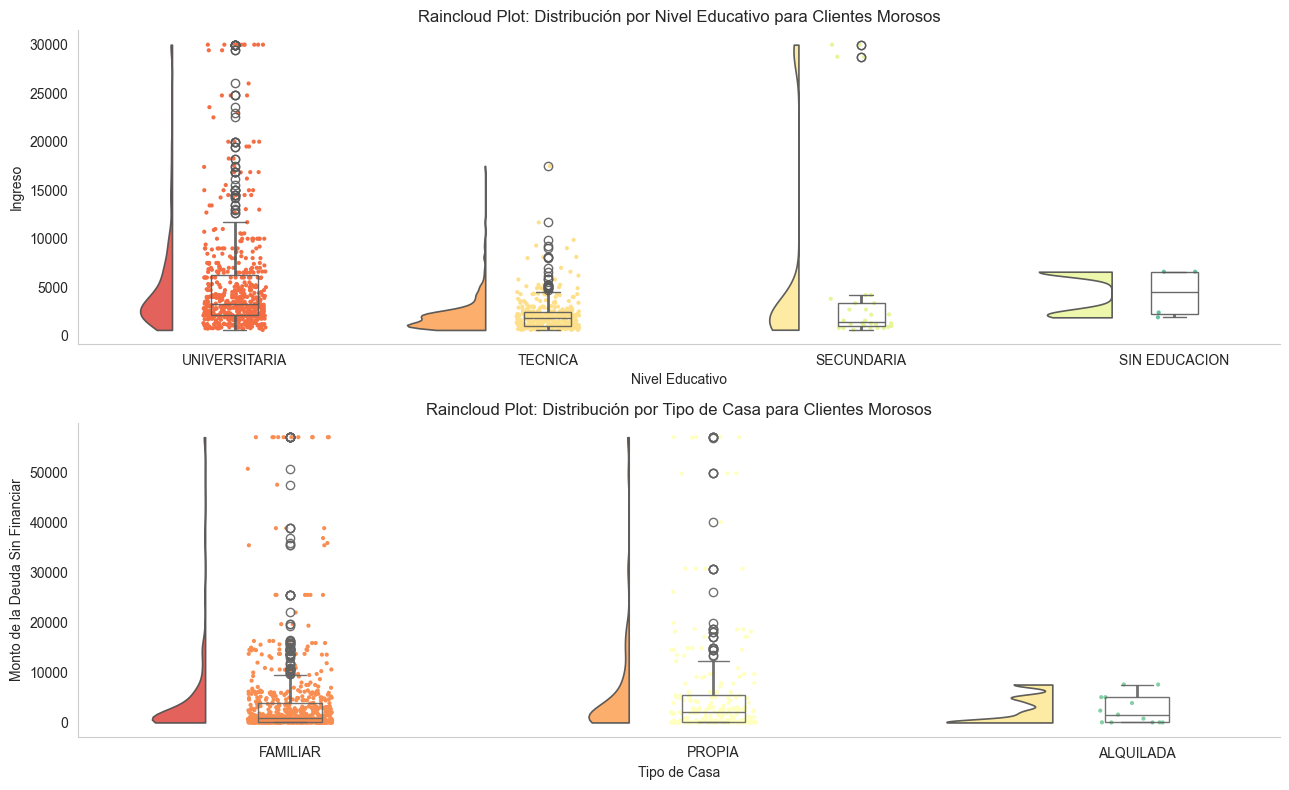

In [13]:
sns.set_style("whitegrid")  # fondo blanco y cuadrícula
fig, axes = plt.subplots(2, 1, figsize=(13, 8))

# Raincloud plot para 'nivel_educ' y 'ingreso' en el primer subgráfico
pt.RainCloud(x="nivel_educ", y="ingreso", data=df[df['default']==1], # SOLO clientes que default=1 (morosos)
                palette='Spectral', bw=0.2, width_viol=0.5, ax=axes[0],
                alpha=0.9, jitter=True, linewidth=1.2) # transparencia, dispersión y grosor de líneas 
axes[0].set_title("Raincloud Plot: Distribución por Nivel Educativo para Clientes Morosos", fontsize=12)
axes[0].set_xlabel("Nivel Educativo", fontsize=10)
axes[0].set_ylabel("Ingreso", fontsize=10)
axes[0].grid(False)
sns.despine(ax=axes[0])
plt.grid(False)

# Raincloud plot para 'housing_type' y 'deuda_sf' en el segundo subgráfico
pt.RainCloud(x="vivienda", y="deuda_sf", data=df[df['default']==1],
                palette='Spectral', bw=0.2, width_viol=0.5, ax=axes[1],
                alpha=0.9, jitter=True, linewidth=1.2)
axes[1].set_title("Raincloud Plot: Distribución por Tipo de Casa para Clientes Morosos", fontsize=12)
axes[1].set_xlabel("Tipo de Casa", fontsize=10)
axes[1].set_ylabel("Monto de la Deuda Sin Financiar", fontsize=10)
axes[1].grid(False)
sns.despine(ax=axes[1])
plt.tight_layout()
plt.show()

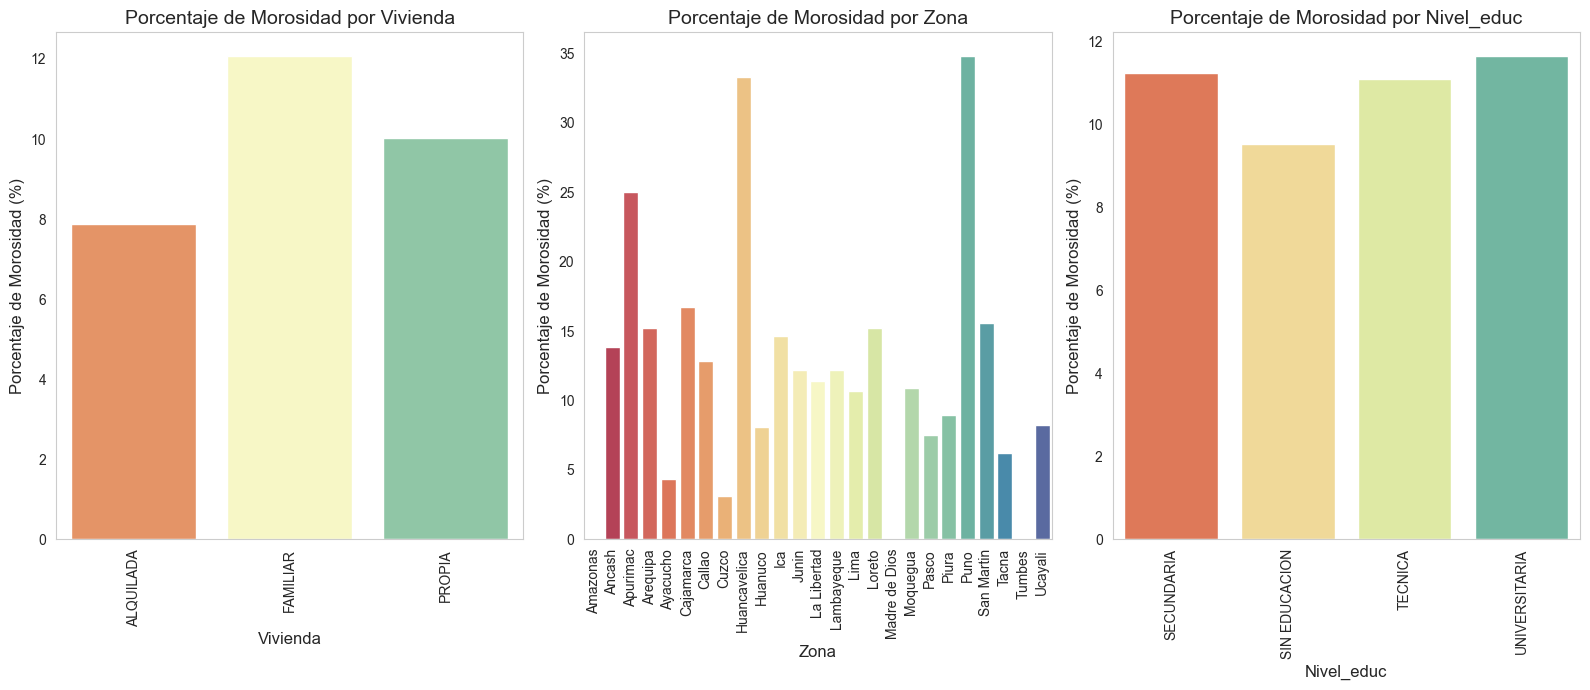

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 7))
for col, ax in zip(v_cat, axes.flatten()): 
    mora_percent = df.groupby(col)['default'].mean().reset_index()
    mora_percent['default'] *= 100 
    sns.barplot(data=mora_percent, x=col, y='default', ax=ax, palette="Spectral")
    ax.set_title(f'Porcentaje de Morosidad por {col.capitalize()}', fontsize=14)
    ax.set_xlabel(col.capitalize(), fontsize=12)
    ax.set_ylabel("Porcentaje de Morosidad (%)", fontsize=12)
    ax.tick_params(axis='x', rotation=90)
    ax.grid(False)
plt.tight_layout()
plt.show()


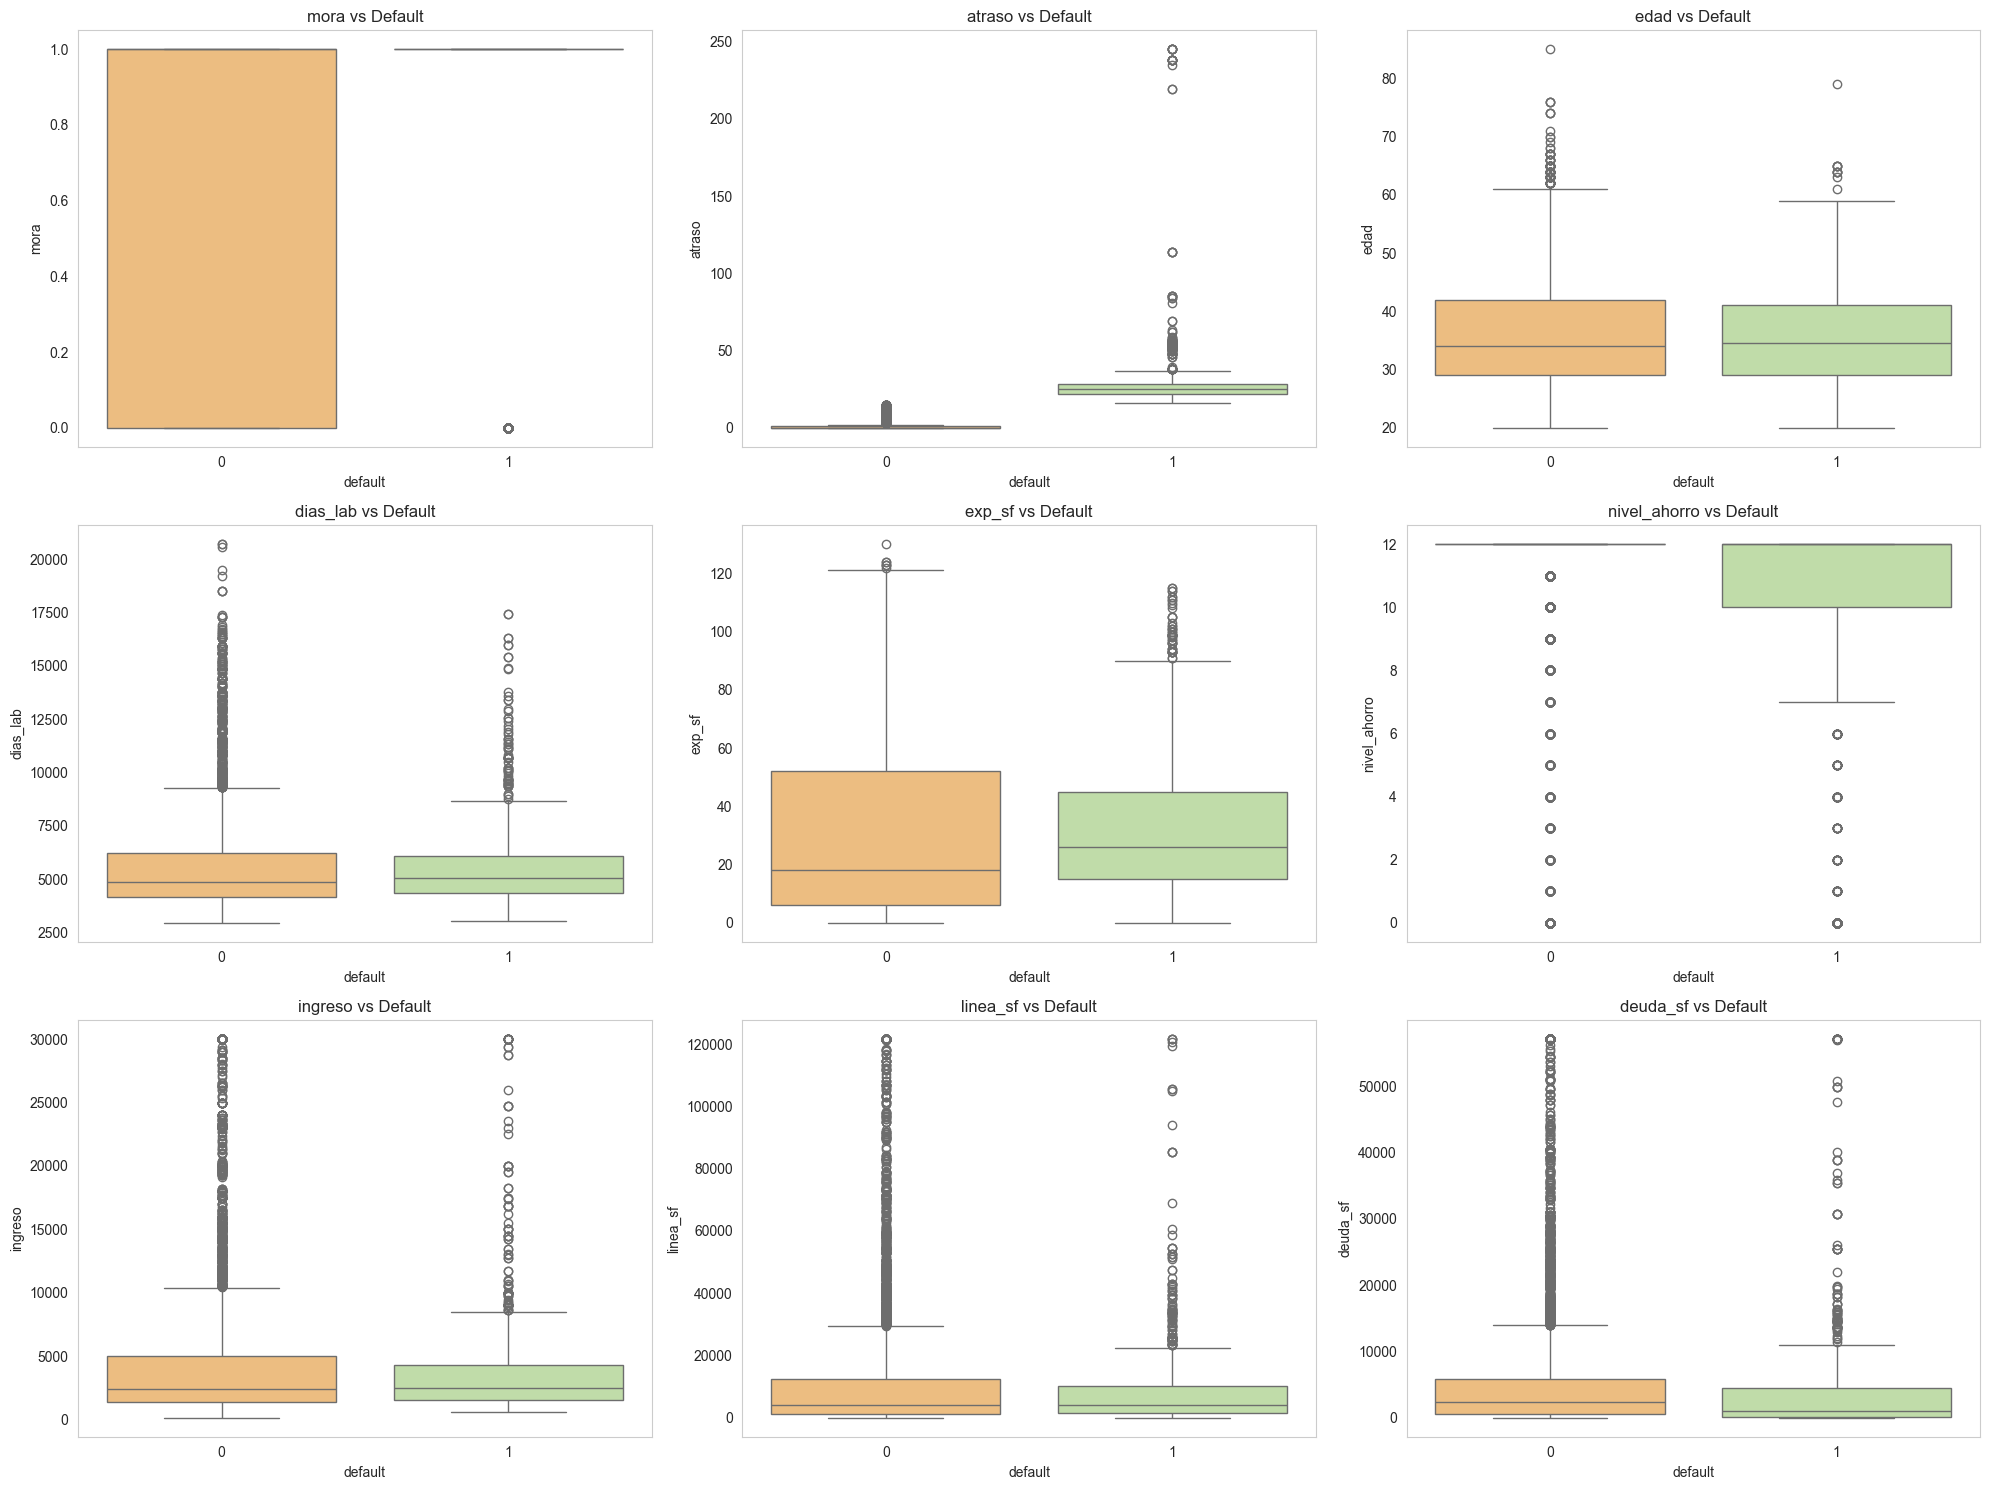

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
for col, ax in zip(v_num, axes.flatten()[:len(v_num)]):
    sns.boxplot(data=df, x='default', y=col, ax=ax, palette="Spectral")
    ax.set_title(f'{col} vs Default')
    ax.grid(False)
plt.tight_layout()
plt.show()

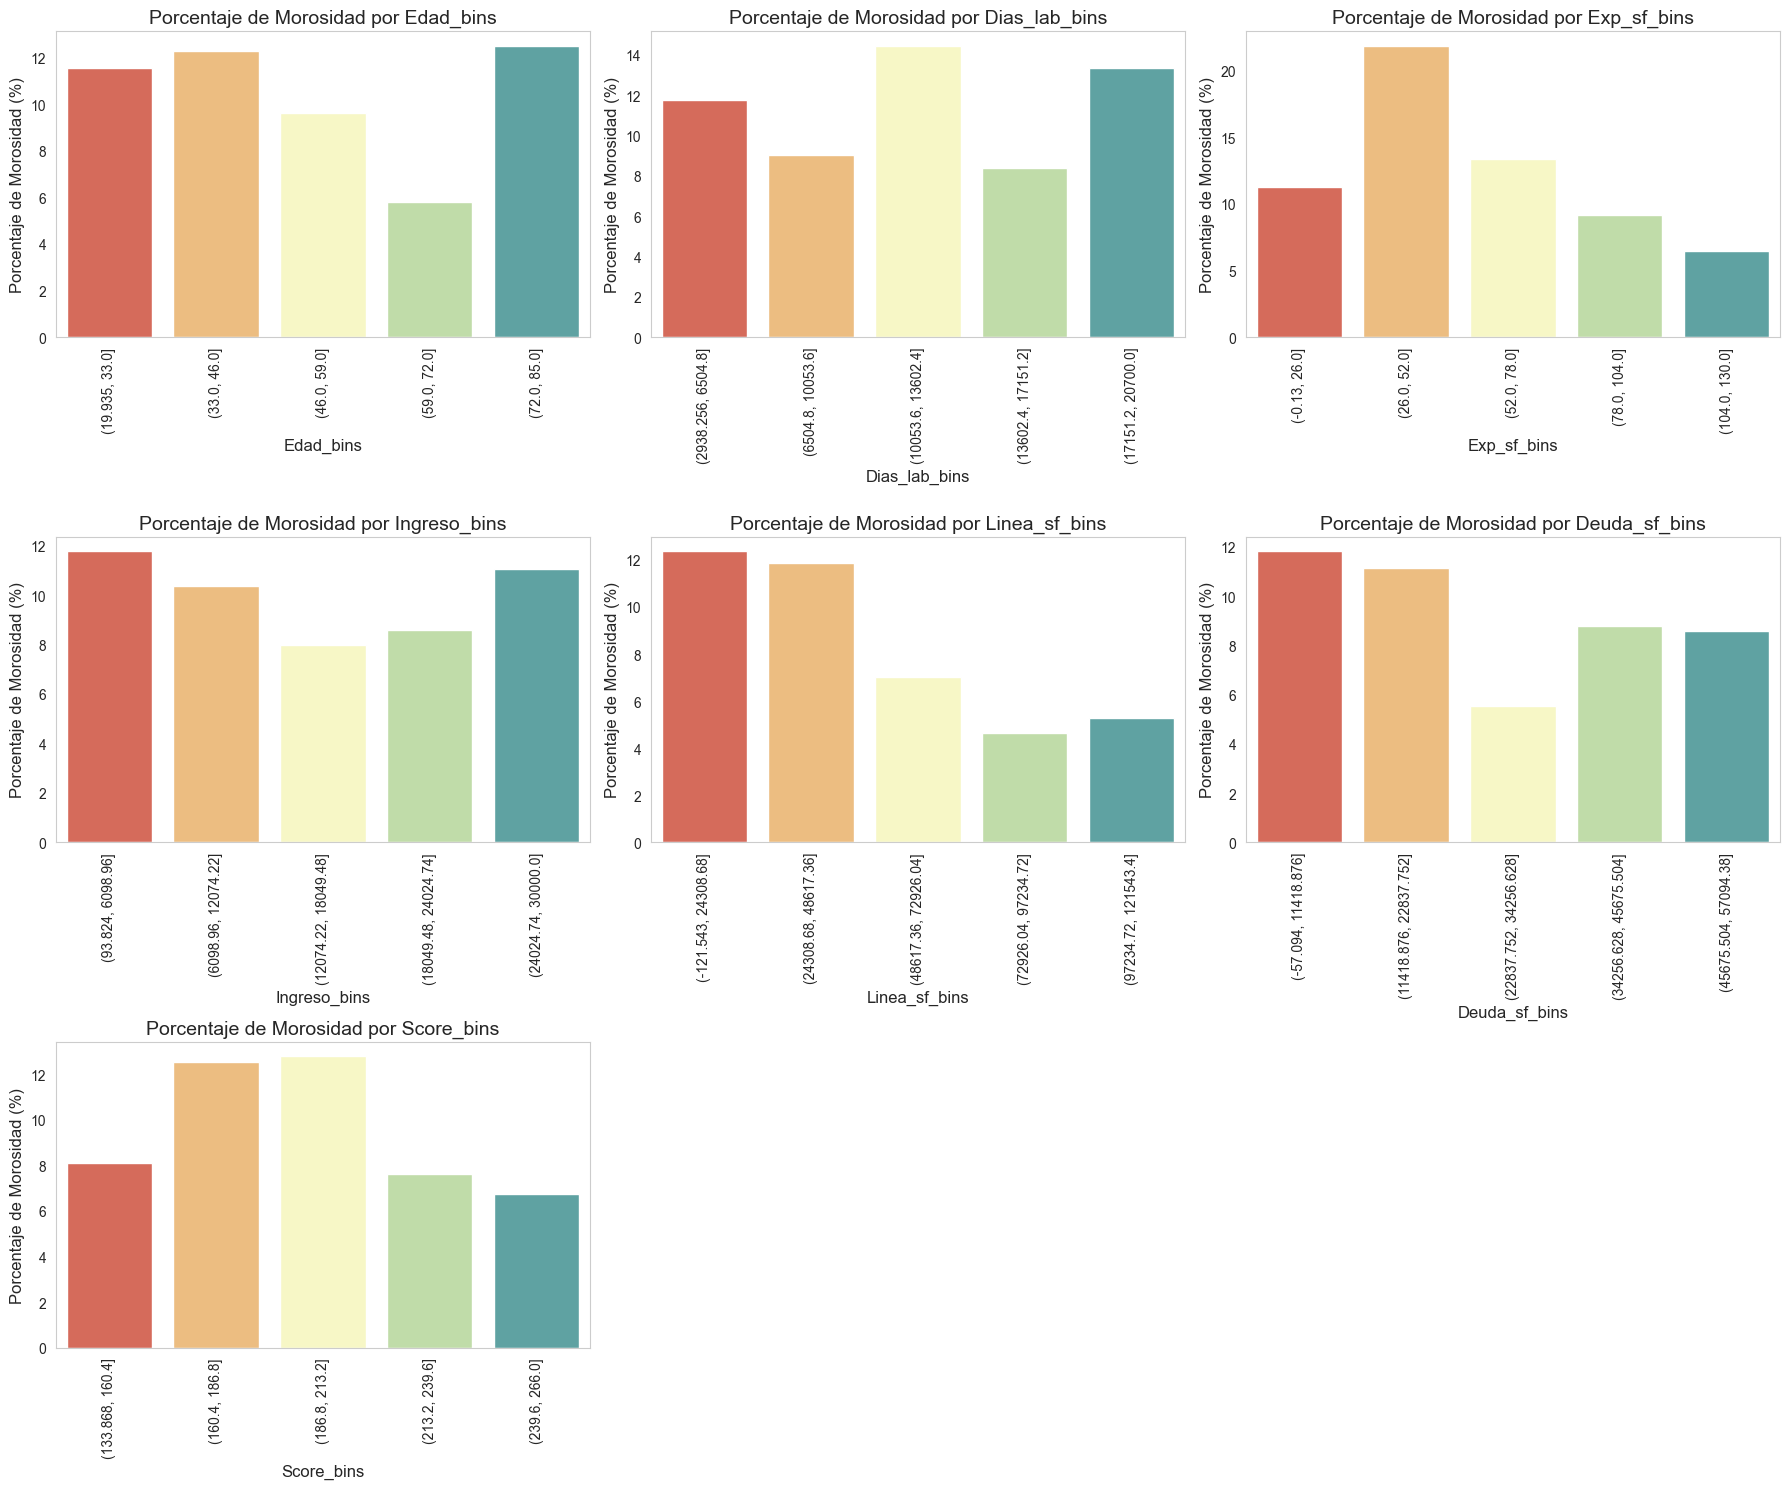

In [16]:
drop = ['mora', 'atraso', 'nivel_ahorro', 'clasif_sbs', 'default']
var = [x for x in v_num if x not in drop]
var_list = []

for i in var:
	df[f'{i}_bins'] = pd.cut(df[i], 5)
	var_list.append(f'{i}_bins')

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 15))
for col, ax in zip(var_list, axes.flatten()): 
    mora_percent = df.groupby(col)['default'].mean().reset_index()
    mora_percent['default'] *= 100 
    sns.barplot(data=mora_percent, x=col, y='default', ax=ax, palette="Spectral")
    ax.set_title(f'Porcentaje de Morosidad por {col.capitalize()}', fontsize=14)
    ax.set_xlabel(col.capitalize(), fontsize=12)
    ax.set_ylabel("Porcentaje de Morosidad (%)", fontsize=12)
    ax.tick_params(axis='x', rotation=90)
    ax.grid(False)

for ax in  axes.flatten()[len(var_list):]:
    ax.set_visible(False)  # o ax.axis('off')
    
plt.tight_layout()
plt.show()

## **2.3 Análisis Multivariado**

Los puntos mas importantes en este punto son:
- Multicolinealidad
- Variables duplicadas conceptualmente
- Correlación con target

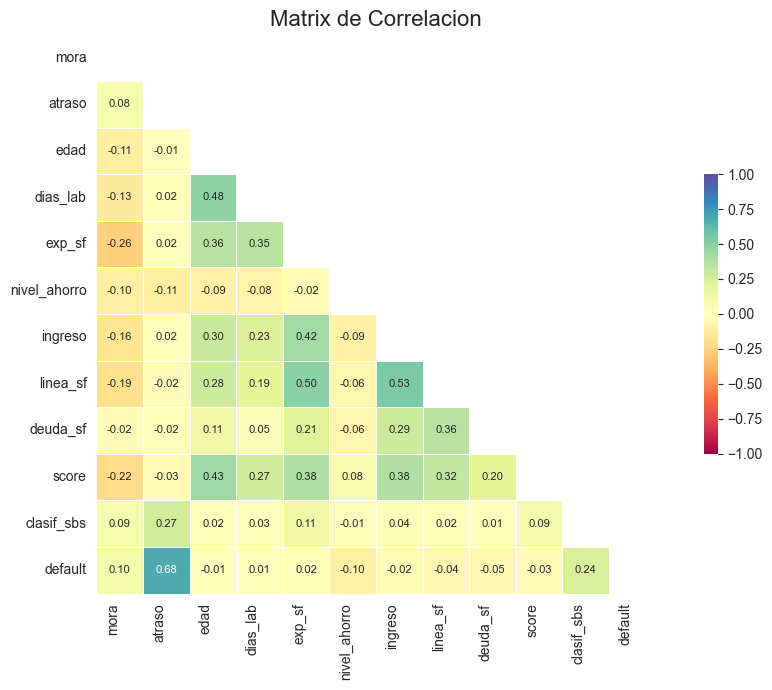

In [17]:
corr = df[v_num].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 7))
sns.set_style("white")  

sns.heatmap(corr, mask=mask, cmap="Spectral", 
            vmin=-1, vmax=1, square=True,
            annot=True, fmt=".2f", annot_kws={"size": 8}, linewidths=0.5,
            cbar_kws={"shrink": 0.5, "aspect": 20}, linecolor='white')

plt.xticks(fontsize=10, rotation=90, ha="right")
plt.yticks(fontsize=10, rotation=0)
plt.title("Matrix de Correlacion", fontsize=16)
plt.tight_layout()
plt.show()

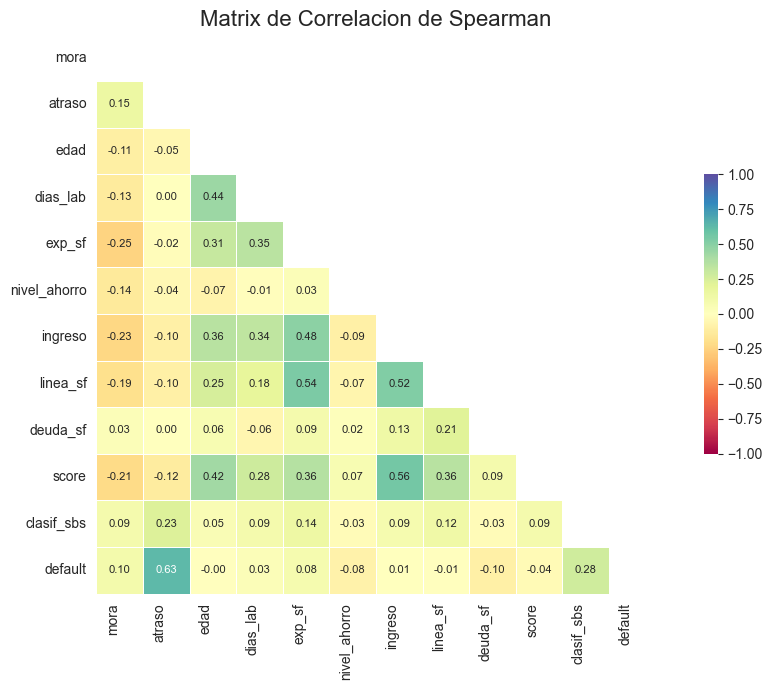

In [18]:
corr = df[v_num].corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 7))
sns.set_style("white")  

sns.heatmap(corr, mask=mask, cmap="Spectral", 
            vmin=-1, vmax=1, square=True,
            annot=True, fmt=".2f", annot_kws={"size": 8}, linewidths=0.5,
            cbar_kws={"shrink": 0.5, "aspect": 20}, linecolor='white')

plt.xticks(fontsize=10, rotation=90, ha="right")
plt.yticks(fontsize=10, rotation=0)
plt.title("Matrix de Correlacion de Spearman", fontsize=16)
plt.tight_layout()
plt.show()

# **3. Tratamiento de Variables**

### **3.1 Consideraciones Iniciales**

- Considerar solo LIMA vs NO LIMA
- Clasificacion de SBS 0: Normal, 1: Resto (CPP, Dudoso, Default)
- La variable ahorro 1:Ahorro Alto y 0: No Ahorro Alto
- Eliminar variables que no se van a utilizar (**Data Leakage**)

In [23]:
df['lima'] = np.where(df['zona'] == 'Lima', 1, 0)
df['sbs_target'] = np.where(df['clasif_sbs'] >= 1, 1, 0)
df['ahorro_target'] = np.where(df['nivel_ahorro'] == 12, 1, 0)

drop_columns = ['mora', 'atraso', 'nivel_ahorro', 'dias_lab_bins', 
                'exp_sf_bins', 'ingreso_bins', 'deuda_sf_bins', 'zona',
                'linea_sf_bins', 'score_bins', 'edad_bins']

df.drop(columns=drop_columns, inplace=True)

### **3.2 Handling Missing Values**

En nuestro dataset solo observamos 3 variables con presencia de missing values. ¿Qué hacemos?

- Imputamos con alguna medida de tendencia central
- Usar un algoritmo avanzado de imputacion (KNN)
- Eliminarlos de la muestra

Pero antes que todo, siempre preguntarse **¿Por qué son missing? ¿Qué significa un missing en esa variable?**

array([[<Axes: title={'center': 'exp_sf'}>,
        <Axes: title={'center': 'linea_sf'}>,
        <Axes: title={'center': 'deuda_sf'}>]], dtype=object)

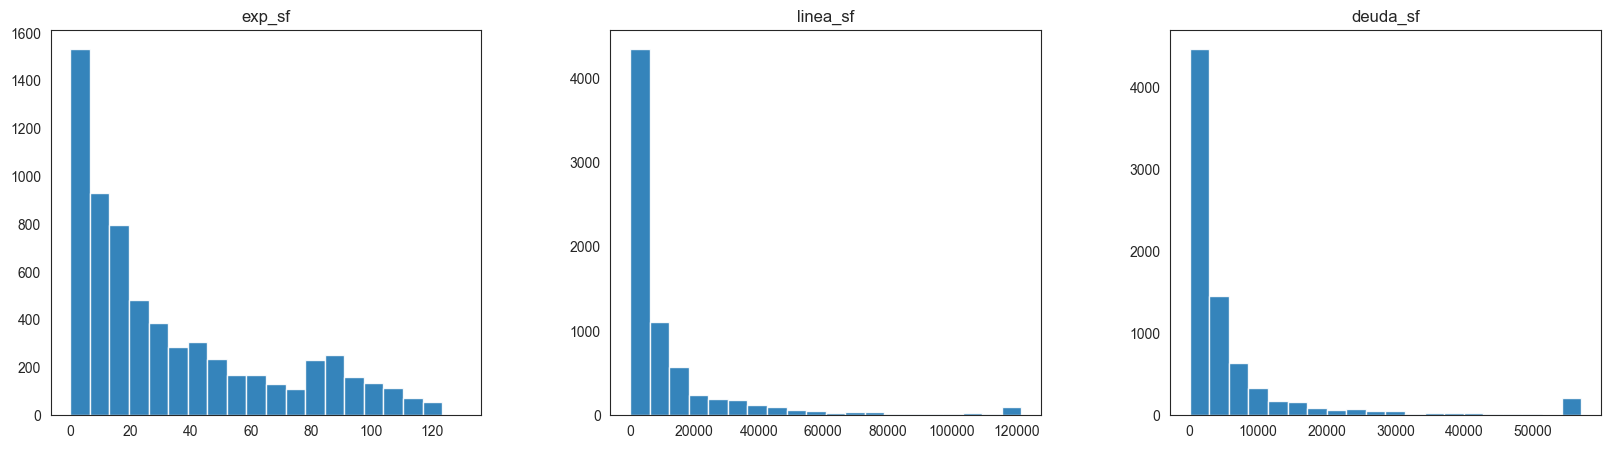

In [24]:
cols = ['exp_sf', 'linea_sf', 'deuda_sf']

df[cols].hist(bins=20, figsize=(20, 5), alpha=0.9, grid=False, layout=(1, 3))

In [25]:
# 1. Casos donde los clientes no tienen información financiera (exp_sf, deuda_sf, linea_sf)
clientes_no_sf = df[(df['exp_sf'].isnull()) & (df['deuda_sf'].isnull()) & (df['linea_sf'].isnull())].shape[0]
print(f"Cantidad de clientes sin información financiera: {clientes_no_sf}")

mask = df[cols].isnull().all(axis=1)
df.loc[mask, cols] = 0
print(f"Registros actualizados: {mask.sum()}")

Cantidad de clientes sin información financiera: 79
Registros actualizados: 79


In [26]:
# 2. Imputar con una medida de tendencia central
imputer = SimpleImputer(strategy='median')
df[cols] = imputer.fit_transform(df[cols])

### **3.3 Outliers**

Si bien la distribucion no es normal en la mayoria de la variables continuas, no vemos un patron excesivamente extremo o valores raros dentro de la distribucion para la naturaleza de cada variables. En caso haber, se sugiere:

```
p99 = df['var1'].quantile(0.99)
df = df[df['var1'] <= p99)
```

### **3.4 Label Encoding**

En esta parte discutimos si vale la pena:

1. Hacer una escala ordinal de las categorias
2. Hacer variables dummies por cada categoria
3. Agrupar categorias 

In [ ]:
educ = {'UNIVERSITARIA': 3,
        'TECNICA': 2,
		'SECUNDARIA': 1,
        'SIN EDUCACION': 0}

vivienda = {'FAMILIAR': 2,
            'PROPIA': 1,
            'ALQUILADA': 0}

df['nivel_educ'] = df['nivel_educ'].map(educ)
df['vivienda'] = df['vivienda'].map(vivienda)

### **3.5 Balance del dataset**
En modelos de credit scoring, el default suele ser un evento poco frecuente. En nuestro caso:

- Default ≈ 11% (puede ser peor)
- No Default ≈ 89%

Esto implica un dataset desbalanceado, lo que puede generar:
- Modelos que predicen casi siempre "no default"
- Alta accuracy pero bajo recall en la clase minoritaria
- Mala detección de clientes riesgosos

Existen algunas tecnicas para poder lidear con esta casuistica:
1. **Undersampling**: Reduce la clase mayoritaria (No Default) para equilibrar el dataset. (PIERDES INFORMACION)
2. **Oversampling**: Duplica observaciones de la clase minoritaria (Default). (OVERFITTING)
   - **SMOTE**: Genera observaciones sintéticas de la clase minoritaria en lugar de duplicarlas.
     - Ventaja: más robusto que oversampling simple
     - Desventaja: puede generar ruido si no se usa correctamente

3. **Parametros**: 
  - class_weight='balanced'
  - scoring='recall'

```
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score


### Balance con Undersampling
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X, y)

### Balanceo con Oversampling (SMOTH)
smote = SMOTE(random_state=42)
X_over, y_over = smote.fit_resample(X, y)


### Parametros
model = LogisticRegression(max_iter=1000)

scores = cross_val_score(model, X, y, cv=5, scoring='recall')
print("Recall promedio:", scores.mean())
```

## **4. Validacion Final**

Validaciones clave antes de modelar

✅ Checklist:

- Target bien definido
- No leakage
- Variables limpias
- Missing tratados
- Outliers evaluados
- Dataset balance revisado

```
“El 80% del performance de un modelo de credit scoring depende de cómo definimos el default y cómo tratamos las variables antes de modelar.”
```

```
“Modelar es fácil. Definir bien el problema no lo es.”
```